#ADMM

In [15]:
import numpy as np
from scipy.linalg import orth
from utills import plot_observation, plot_convergence
import torch.nn as nn

np.random.seed(0)

ADMM implementation

In [16]:
class ADMM(nn.Module):
    def __init__(self, H, mu, lambda_, max_iter, eps, rho):
        super(ADMM, self).__init__()

        # Solver parameters
        self.mu = mu
        self.max_iter = max_iter
        self.eps = eps

        self.rho = rho
        self.lambda_ = lambda_

        # Objective parameters
        self.H = H

        # left_term = (H^TH+2λI)^-1
        self.left_term = np.linalg.inv(self.H.T.dot(self.H) + np.eye(self.H.shape[1]).dot(self.rho))

        # initial estimate
        self.s = np.zeros((H.shape[1], 1))
        self.u = np.zeros((H.shape[1], 1))
        self.v = np.zeros((H.shape[1], 1))

    def shrinkage(self, x, beta):
        # Shrinking towards 0 by Beta parameter.
        return np.multiply(np.sign(x), np.maximum(np.abs(x) - beta, 0))

    def forward(self, x):

        recovery_errors = []
        for k in range(self.max_iter):
            s_prev, v_prev, u_prev = self.s, self.v, self.u

            # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).
            right_term = H.T.dot(x) + self.rho * (v_prev - u_prev)
            self.s = self.left_term @ right_term

            # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
            self.v = self.shrinkage(self.s + u_prev, self.rho / (2 * self.lambda_))

            # Update uk+1 = uk + μ (sk+1 − vk+1).
            self.u = u_prev + self.mu * (self.s - self.v)

            # cease if convergence achieved
            if np.sum(np.abs(self.s - s_prev)) <= self.eps:  break

            # save recovery error
            recovery_errors.append(np.sum((np.dot(self.H, self.s) - x) ** 2))

        print("ADMM converged after {0} iterations for epsilon: {1}".format(k+1, self.eps))
        return self.s, recovery_errors

Generating an example of a sparse signal

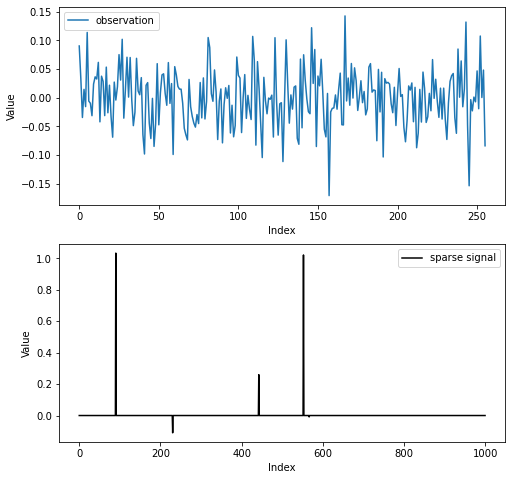

In [17]:
# Signal configuration parameters
m, n, k = 1000, 256, 5
Psi = np.eye(m)
Phi = np.random.randn(n, m)
Phi = np.transpose(orth(np.transpose(Phi)))
H = Phi

# Generate a sparse signal
s_gt = np.zeros((1, m))
index_k = np.random.choice(m, k, replace=False)
s_gt[:, index_k] = 0.5 * np.random.randn(k, 1).reshape([1, k])

# x = Hs+w s.t w~N(0,1) nxm x m1
x = np.dot(H, s_gt.T) + 0.01 * np.random.randn(n, 1)

plot_observation(x, s_gt)

ADMM setup

ADMM converged after 10000 iterations for epsilon: 1e-05


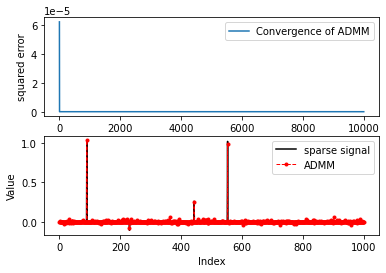

In [19]:
step_size = 0.00005
max_iter = 10000
rho = 0.01
lambda_ = 12.5
eps_threshold = 1e-5

ADMM_model = ADMM(H, step_size, lambda_, max_iter, eps_threshold, rho)
s_hat, errors = ADMM_model(x)

plot_convergence(s_gt=s_gt,s_hat=s_hat,errors=errors)